Setup

In [1]:
!wget -O carpet.tar.xz "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz"

!mkdir -p mvtec/
!tar -xf carpet.tar.xz -C mvtec/
from torchvision import transforms
from torchvision.datasets import ImageFolder


transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_images_path = "mvtec/carpet/train"
good_dataset = ImageFolder(train_images_path, transform=transform)
import torch
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


--2025-07-10 11:44:40--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740285760 (706M) [application/x-xz]
Saving to: ‘carpet.tar.xz’

carpet.tar.xz       100%[===================>] 705.99M  20.4MB/s    in 36s     

2025-07-10 11:45:17 (19.5 MB/s) - ‘carpet.tar.xz’ saved [740285760/740285760]



In [2]:
import torch.nn.functional as F
from torch import nn
from PIL import Image


input_image = Image.open('mvtec/carpet/train/good/000.png')
input_image = transform(input_image)

input_image = input_image.unsqueeze(0) # adds an extra dimension (represnting batch size)
print(input_image.shape)

c1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4)
# get 128 features maps out, so its 128 kernels, each kernel is 4x4x3, each feature map would be 224 - 4 + 1 (stride 1, padding = 0)
x = c1(input_image)
print(x.shape)
ap1 = nn.AvgPool2d(kernel_size=2, stride=2 )
# average pooling is better for anamoly detection
# floor((221 - 2)/2) + 1
x = ap1(x)
print(x.shape)
c2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
# 110 x 110 ->  110 - 4 + 1 = 107
ap2 = nn.AvgPool2d(kernel_size=2, stride=2 )
x= ap2(c2(x)) # 107 - 2 / 2 + 1 = 53
print(x.shape)
c3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3 )
ap3 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap3(c3(x))
print(x.shape)

# upscaling operation
c4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, output_padding=1 )
x = c4(x)
print(x.shape)
c5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, output_padding=1 )
x = c5(x)
print(x.shape)
c6 = nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=5, stride=2, output_padding=1 )
x = c6(x)
print(x.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 128, 221, 221])
torch.Size([1, 128, 110, 110])
torch.Size([1, 256, 53, 53])
torch.Size([1, 256, 25, 25])
torch.Size([1, 256, 53, 53])
torch.Size([1, 128, 110, 110])
torch.Size([1, 3, 224, 224])


In [3]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, output_padding=1 ),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid() # match range of input image
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
input_image = torch.randn(1, 3, 224, 224)  # Sample input image
output_image = model(input_image)
print(output_image.shape)  # Print the shape of the output image

torch.Size([1, 3, 224, 224])


In [4]:
model.cuda()# Move the model to the GPU
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt

  1%|          | 1/100 [00:15<25:05, 15.20s/it]

Epoch [1/100], Loss: 0.0170, Validation Loss: 0.0156


  6%|▌         | 6/100 [01:25<22:10, 14.15s/it]

Epoch [6/100], Loss: 0.0132, Validation Loss: 0.0127


 11%|█         | 11/100 [02:35<20:46, 14.00s/it]

Epoch [11/100], Loss: 0.0115, Validation Loss: 0.0114


 16%|█▌        | 16/100 [03:46<19:42, 14.07s/it]

Epoch [16/100], Loss: 0.0077, Validation Loss: 0.0075


 21%|██        | 21/100 [04:56<18:32, 14.08s/it]

Epoch [21/100], Loss: 0.0060, Validation Loss: 0.0058


 26%|██▌       | 26/100 [06:08<17:46, 14.42s/it]

Epoch [26/100], Loss: 0.0052, Validation Loss: 0.0053


 31%|███       | 31/100 [07:18<16:13, 14.10s/it]

Epoch [31/100], Loss: 0.0049, Validation Loss: 0.0049


 36%|███▌      | 36/100 [08:29<15:00, 14.07s/it]

Epoch [36/100], Loss: 0.0049, Validation Loss: 0.0048


 41%|████      | 41/100 [09:40<13:55, 14.16s/it]

Epoch [41/100], Loss: 0.0046, Validation Loss: 0.0046


 46%|████▌     | 46/100 [10:51<12:44, 14.15s/it]

Epoch [46/100], Loss: 0.0044, Validation Loss: 0.0045


 51%|█████     | 51/100 [12:01<11:32, 14.14s/it]

Epoch [51/100], Loss: 0.0043, Validation Loss: 0.0043


 56%|█████▌    | 56/100 [13:11<10:17, 14.04s/it]

Epoch [56/100], Loss: 0.0040, Validation Loss: 0.0042


 61%|██████    | 61/100 [14:22<09:09, 14.09s/it]

Epoch [61/100], Loss: 0.0041, Validation Loss: 0.0040


 66%|██████▌   | 66/100 [15:32<07:58, 14.09s/it]

Epoch [66/100], Loss: 0.0038, Validation Loss: 0.0039


 71%|███████   | 71/100 [16:43<06:50, 14.16s/it]

Epoch [71/100], Loss: 0.0038, Validation Loss: 0.0038


 76%|███████▌  | 76/100 [17:55<05:44, 14.34s/it]

Epoch [76/100], Loss: 0.0037, Validation Loss: 0.0037


 81%|████████  | 81/100 [19:07<04:30, 14.24s/it]

Epoch [81/100], Loss: 0.0037, Validation Loss: 0.0037


 86%|████████▌ | 86/100 [20:18<03:17, 14.14s/it]

Epoch [86/100], Loss: 0.0036, Validation Loss: 0.0036


 91%|█████████ | 91/100 [21:29<02:07, 14.12s/it]

Epoch [91/100], Loss: 0.0035, Validation Loss: 0.0036


 96%|█████████▌| 96/100 [22:39<00:56, 14.11s/it]

Epoch [96/100], Loss: 0.0033, Validation Loss: 0.0035


100%|██████████| 100/100 [23:35<00:00, 14.16s/it]


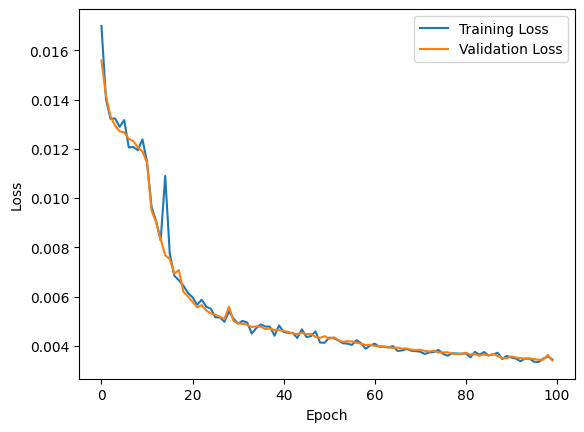

In [12]:
Loss = []
Validation_loss = []
num_epochs = 100

for epoch in tqdm(range(num_epochs)):
  model.train()
  for images, _ in train_loader:
    # print(img.shape) [16,3,224,244]
    images = images.cuda()
    output_images = model(images)
    # print(output.shape) [16,3,224,244]
    loss = criterion(output_images, images)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  Loss.append(loss.item()) # this is only for the latest batch of 16 items

  model.eval()
  with torch.no_grad():
    val_loss_sum = 0.0
    num_batches=0
    for images, label in test_loader:
      images = images.cuda()
      output_images = model(images)
      val_loss = criterion(output_images, images)
      val_loss_sum += val_loss.item()
      num_batches += 1
    val_loss_avg = val_loss_sum / num_batches
    Validation_loss.append(val_loss_avg) # for all 56 images

  if epoch % 5 == 0:
    print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


wow, training loss is not much lesser than validation, so no overfitting? that too from the start, not too spiky, batch size is not too small. Training loss spikes are probably because we are only consider training loss in the last batch of the epoch, instead of all batches

there is a possibility it keeps decreasing after 100 epochs? can train for 100 ish more epochs, and pick the weights which give lowest validation loss

In [13]:
torch.save(model.state_dict(), 'autoencoder_carpets_l2loss_100epochs.pth')

In [20]:
# lets take a sample from training data (train+val) and see how it reconstructs
def compare(img_path: str, model: torch.nn.Module) -> None:

    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).cuda()

    model.eval()
    with torch.no_grad():
        output_tensor = model(input_tensor)

    original = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    reconstructed = output_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


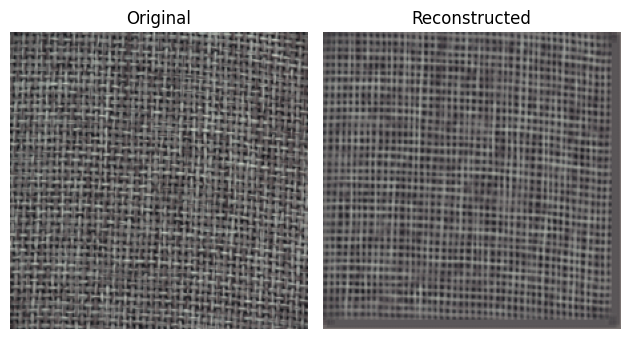

In [22]:
compare("mvtec/carpet/train/good/001.png",model)

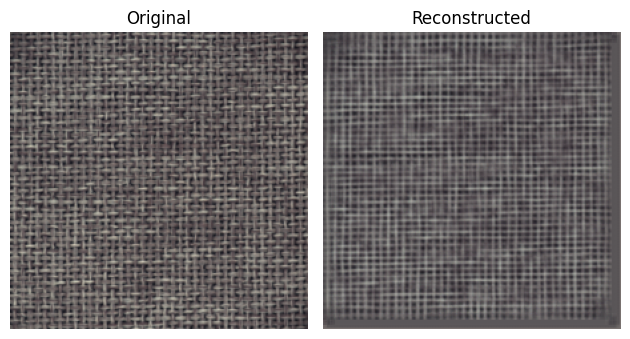

In [23]:
compare("mvtec/carpet/test/good/002.png",model)

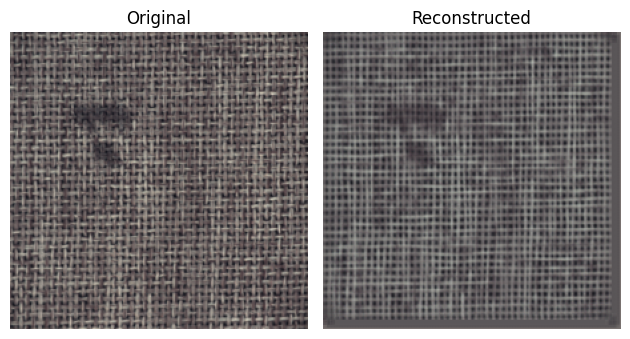

In [24]:
compare("mvtec/carpet/test/color/002.png",model)

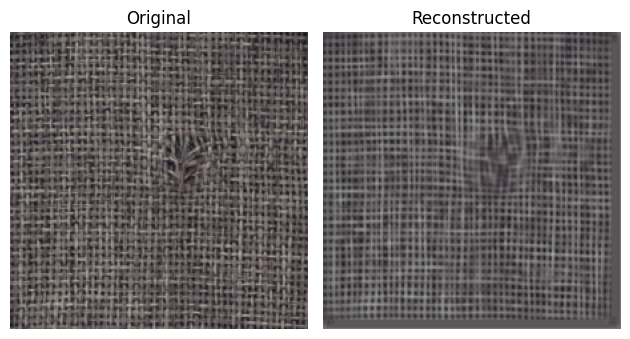

In [25]:
compare("mvtec/carpet/test/cut/002.png",model)


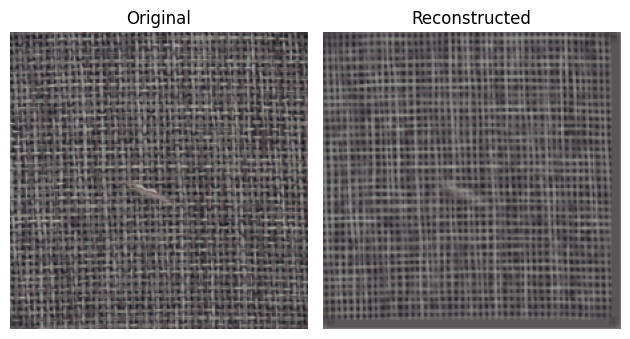

In [26]:
compare("mvtec/carpet/test/thread/002.png",model)
